In [20]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pyexpat import model
import pandas as pd
from scripts.util import  join_text, clean_text,tokenize, calculate_word_freq
from sklearn.model_selection import train_test_split
from scripts.nlp_func import build_w2v_model, build_model, build_d2v_model, evaluate_model, plot_confusion_matrix
import gensim
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scripts.util import clean_text
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.metrics import confusion_matrix

stopwords = nltk.corpus.stopwords.words("english")

## Business understanding

Spam is unsolicited and unwanted messages sent electronically whose content may be malicious. The danger could be: exposure of pravicy, a fraud, or a virus,etc. It is a major problem for email users, and it is a growing problem for mobile phone users. We need a solution to detect spam messages. Before that, we need to understand what are the common words and pattern in the SMS spam messages? Can we build a model to detect spam messages?  What is the confidence level of the model? How can we filter out spam messages? 

## Data understanding

The dataset is from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). It contains 5574 SMS messages. The dataset is a collection of more than 5 thousand SMS phone messages. It is a public available dataset for research. The data is labeled, which means each message is labeled as spam or ham. The dataset is a text file, and each line is a message. The first word is the label, and the rest of the message is the text. Original dataset has some nosisy information, e.g. unwanted columns, and some messages are not in English. The dataset need to be cleaned and preprocessed for further analysis.


## Access and explore the data

Only query the first two columns data, and assign the columns name as "label" and "text", remove the Unwanted columns.

In [71]:
df=pd.read_csv('data/spam.csv',header=0, encoding="ISO-8859-1",usecols=[0,1], names=['label', 'text'])
print(f"Shape of the dataset: {df.shape}")
print(f"samples of the dataset: {df.head()}")

Shape of the dataset: (5572, 2)
samples of the dataset:   label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


Check the null values in the dataset

In [88]:
df.isna().sum()

label         0
text          0
clean_text    0
dtype: int64

For this dataset, there is no missing value.

Clean the text by removing punctuation, lowercasing, removing stopwords

In [72]:
def clean_text(text: str) -> str:
    """
    Clean text by removing punctuation, lowercasing, removing stopwords

    args:
        text: raw text to be cleaned
    returns:
        cleaned text
    """
    stopwords = nltk.corpus.stopwords.words("english")
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split("\W+", text)
    text = [word for word in tokens if word not in stopwords]
    return text

df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
df['clean_text'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: clean_text, dtype: object

Exploration: how many spam and ham messages are there?

In [73]:
counts=df.label.value_counts()
ham_ratio=round(counts[0]/counts.sum(),2)
spam_ratio=round(counts[1]/counts.sum(),2)
print(counts)
print(f"This is imbalanced data. The ratio of ham to spam is {ham_ratio}:{spam_ratio}")


ham     4825
spam     747
Name: label, dtype: int64
This is imbalanced data. The ratio of ham to spam is 0.87:0.13


### Question 1: What are the common words and pattern in spam/ ham messages?

Create utility function to calculate the word frequency

In [18]:
def join_text(text):
    """
    Join the list of words into a string separated by space, and return the result.
    """
    return " ".join(text)

def tokenize(text):
    """
    Tokenizes the text.
    Args:
        text: The text to tokenize.
    Returns:
        tokens: The tokens of the text.
    """

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [
        lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words("english")
    ]

    return clean_tokens


def calculate_word_freq(text, tokenizer):
    """
    Calculate the frequency of each word in the text, and return the result as a list of tuples.
    Args:
        text: The text to calculate the word frequency.
        tokenizer: The tokenizer to use.
    Returns:
        word_freq: The word frequency of the text.
    """
    clean_text = tokenizer(text)
    freq = {}  # stores the frequency of elements
    for x in clean_text:
        freq[x] = clean_text.count(x)

    sort_word = pd.DataFrame(freq.items(), columns=["Word", "Frequency"]).sort_values(
        by="Frequency", ascending=False
    )
    return sort_word


words frequency in spam messages

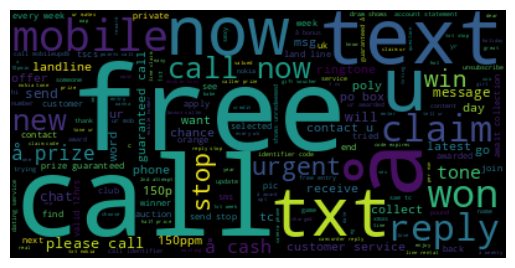

In [13]:
# join all the spam messages into one text 
spam_text= "".join([word.lower() for word in join_text(df[df.label=='spam'].text) if word not in string.punctuation])
# create the word cloud
wordcloud=WordCloud().generate(spam_text)
# plot the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 Spam Words')

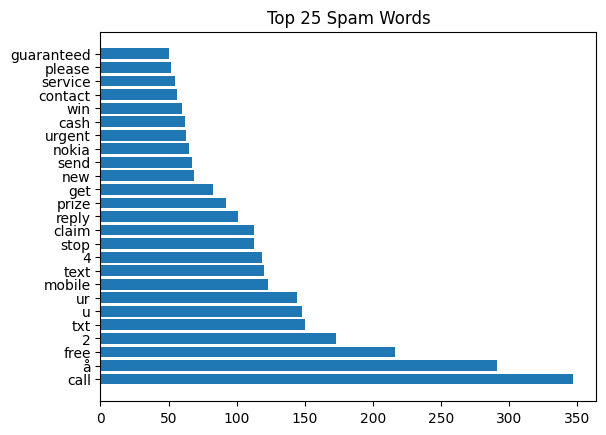

In [14]:
# calculate each words frequency in spam text
sort_spam_word=calculate_word_freq(spam_text,clean_text)
# get the top 25 words and visualize them in the bar chart
top_N=25
plt.barh(sort_spam_word['Word'][:top_N], sort_spam_word['Frequency'][:top_N])
plt.title(f"Top {top_N} Spam Words")

According to the wordcloud diagram and bar chart, we can see that spam messages tend to use more words like “free”, “call”, “text”, “urgent”, ,”cash”,’prize”,”win” etc. Those texts promiss something for free, or urge the receiver to take action.

Words frequency in ham messages

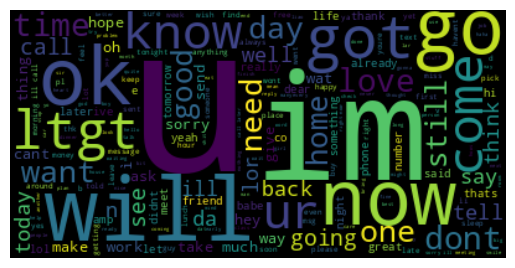

In [15]:
# join all the ham messages into one text 
ham_text= "".join([word.lower() for word in join_text(df[df.label=='ham'].text) if word not in string.punctuation])
# create the word cloud of ham messages
wordcloud=WordCloud().generate(ham_text)
# plot the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 ham Words')

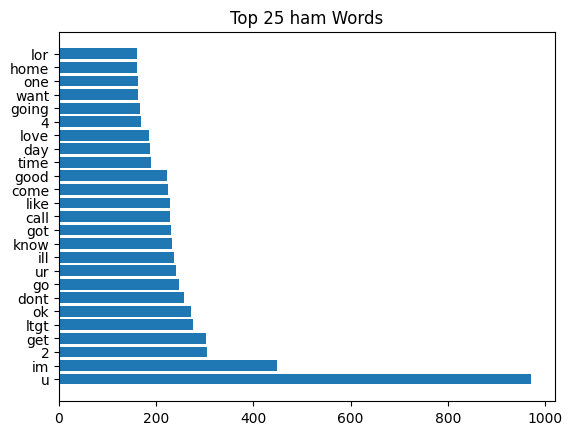

In [16]:
# calculate each words frequency in ham text
sort_ham_word=calculate_word_freq(ham_text,clean_text)
# get the top 25 words and visualize them in the bar chart
top_N=25
plt.barh(sort_ham_word['Word'][:top_N], sort_ham_word['Frequency'][:top_N])
plt.title(f"Top {top_N} ham Words")

In comparison, for the ham word cloud and bar chart, those neutral verb words like “call”,”come”,”go”,”get” etc. are used mostly.

## Question 2: Can we build a model to detect spam messages based on the text? 

Convert the label from category to int, so that it can be evaluated.

In [74]:
# spam:1, ham:0
df["label"] = np.where(df["label"] == "ham", 0, 1)
df["clean_text"] = df["text"].apply(lambda x: clean_text(x))

Randomly split the data into training and testing sets,since the dataset is small, we use 80% for training and 20% for testing.

In [78]:
X_train, X_test, y_train, y_test_clean = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42
)
print(f" X_train shape: {X_train.shape}", f" X_test shape: {X_test.shape}")
print(f" y_train shape: {y_train.shape}", f" y_test shape: {y_test_clean.shape}")
print(f" y_train spam ratio: {round(y_train.sum()/y_train.shape[0],2)}")
print(f" y_test spam ratio: {round(y_test_clean.sum()/y_test_clean.shape[0],2)}")

 X_train shape: (4457,)  X_test shape: (1115,)
 y_train shape: (4457,)  y_test shape: (1115,)
 y_train spam ratio: 0.13
 y_test spam ratio: 0.13


### build model based on word2vec and evaluate its performance

Word2vec is a group of related models that are used to produce word embeddings. Word embeddings are an approach to provide a dense representation of words and their relative meanings. The word2vec model is a two-layer neural network that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. The word2vec model is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of words. The model can be used to generate word embeddings that can be used in downstream natural language processing tasks.

In [76]:
# create a custom word2vec vectors transformer
class w2vTransformer(BaseEstimator, TransformerMixin):

    """
    Wrapper class for running word2vec into pipelines and FeatureUnions
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None):
        # persist model for later use
        w2v_model = gensim.models.Word2Vec(X, vector_size=100, window=5, min_count=2)
        self.model = w2v_model
        return self

    def transform(self, X):
        X = X.copy()
        words = set(self.model.wv.index_to_key)
        X_vect = np.array(
            [np.array([self.model.wv[i] for i in ls if i in words]) for ls in X],
            dtype=object,
        )
        X_vect_avg = []
        for i in X_vect:
            if len(i) > 0:
                X_vect_avg.append(np.mean(i, axis=0))
            else:
                X_vect_avg.append(np.zeros(100))

        return np.array(X_vect_avg)

    def get_feature_names(self):
        return self.model.wv.index2word

    def get_params(self, deep=True):
        return {"model": self.model}


def build_w2v_model(estimator=RandomForestClassifier()):
    """
    Build a pipeline that includes:
        - w2vTransformer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("w2v", w2vTransformer()),
            ("classifier", estimator),
        ]
    )
    return pipeline

In [79]:
# Train a classifier using the word2vec transformer and a random forest classifier
rf_word2vec_model = build_w2v_model()
print("Fitting word2vec model...")
rf_word2vec_model.fit(X_train, y_train)
y_pred_rf_word2vec = rf_word2vec_model.predict(X_test)

Fitting word2vec model...


### build model based on doc2vec 

doc2vec is an extension of word2vec that is specifically designed to work with documents. It is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of documents. The model can be used to generate document embeddings that can be used in downstream natural language processing tasks.

In [60]:
class d2vTransformer(BaseEstimator, TransformerMixin):

    """
    Wrapper class for running doc2vec into pipelines and FeatureUnions
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None):
        # persist model for later use
        tagged_docs = [
            gensim.models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(X)
        ]
        d2v_model = gensim.models.Doc2Vec(
            tagged_docs, vector_size=100, window=5, min_count=2
        )
        self.model = d2v_model

        return self

    def transform(self, X):
        tagged_docs_X = [
            gensim.models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(X)
        ]
        X_vect = [self.model.infer_vector(eval(str(v.words))) for v in tagged_docs_X]

        return X_vect

    def get_feature_names(self):
        return self.model.docvecs.index2entity

    def get_params(self, deep=True):
        return {"model": self.model}


def build_d2v_model(estimator=RandomForestClassifier()):
    """
    Build a pipeline that includes:
        - w2vTransformer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("w2v", d2vTransformer()),
            ("classifier", estimator),
        ]
    )
    return pipeline

In [80]:
# train a classifier using the doc2vec transformer and a random forest classifier
rf_doc2vec_model = build_d2v_model()
print("Fitting doc2vec model...")
rf_doc2vec_model.fit(X_train, y_train)
y_pred_rf_doc2vec = rf_doc2vec_model.predict(X_test)

Fitting doc2vec model...


### build model based on TF-IDF

TFIDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. TFIDF is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use TFIDF.

In [62]:
def build_TFIDF_model():
    """
    Build a pipeline that includes:
        - TfidfVectorizer
        - RandomForestClassifier
    """
    pipeline = Pipeline(
        [
            ("tfidf", TfidfVectorizer(tokenizer=clean_text)),
            ("classifier", RandomForestClassifier(n_estimators=100)),
        ]
    )
    return pipeline


In [81]:
X_train, X_test, y_train, y_test_unclean = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)
rf_TFIDF_model = build_TFIDF_model()
rf_TFIDF_model.fit(X_train, y_train)
y_pred_rf_tfidf = rf_TFIDF_model.predict(X_test)

# Question 3: How to choose the best model for business purpose?

Accuracy is not a good measure for imbalanced classification, since it will always be high as long as the majority class is predicted correctly. We need to use other metrics to evaluate the model performance. Here, we use precision, recall, and F1 score to evaluate the model performance. In addition, we use confusion matrix to visualize the model performance.

In [64]:
from sklearn.metrics import f1_score
def evaluate_model(y_test, y_pred):
    """
    Evaluate model performance
    Args:
        y_test: true labels
        y_pred: predicted labels
    Returns:
        None
    """
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_scores = f1_score(y_test, y_pred,average='weighted')
    print(
        "Precision: {} / Recall: {} / F1 score: {}".format(
            round(precision, 3),
            round(recall, 3),
            round(f1_scores, 3),
        )
    )

def plot_confusion_matrix(cm: np.array):
    """
    Plot confusion matrix
    Args:
        cm: confusion matrix
    Returns:
        None
    """
    fig, ax = plt.subplots(1, figsize=(4, 4))
    sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="Blues")
    ax.set_title("Confusion matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    fig.tight_layout()
    plt.show()

Evaluate the performance of the model of word2vec on the test set

Evaluating model...
Precision: 1.0 / Recall: 0.587 / F1 score: 0.938


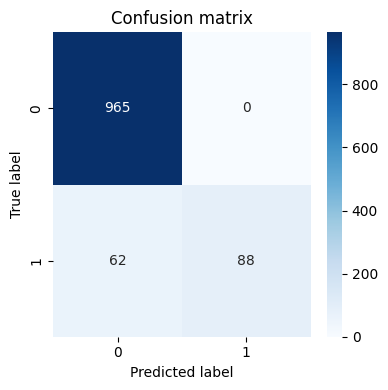

In [82]:
print("Evaluating model...")
evaluate_model(y_test_clean, y_pred_rf_word2vec)
# create confusion matrix
cm=confusion_matrix(y_test_clean,  y_pred_rf_word2vec)
plot_confusion_matrix(cm)

Evaluate the performance of the model of doc2vec on the test set

Evaluating model...
Precision: 0.981 / Recall: 0.687 / F1 score: 0.953


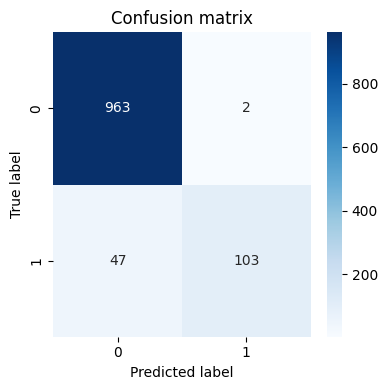

In [83]:
print("Evaluating model...")
evaluate_model(y_test_clean, y_pred_rf_doc2vec)
# create confusion matrix
cm=confusion_matrix(y_test_clean,  y_pred_rf_doc2vec)
plot_confusion_matrix(cm)



Evaluate the performance of the model of TFIDF on the test set

Evaluating model...
Precision: 1.0 / Recall: 0.827 / F1 score: 0.976


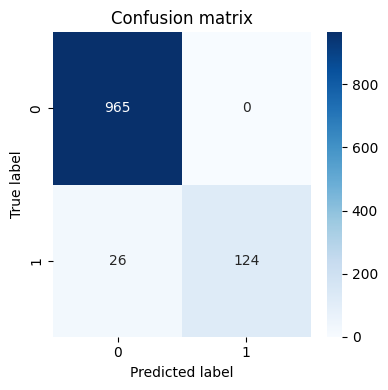

In [84]:
print("Evaluating model...")
evaluate_model(y_test_unclean, y_pred_rf_tfidf)
# create confusion matrix
cm=confusion_matrix(y_test_unclean,  y_pred_rf_tfidf)
plot_confusion_matrix(cm)

In comparison, the model based on TFIDF has the best performance. The precision, recall, and F1 score are all higher than the other two models. The confusion matrix also shows that the model based on TFIDF has the best performance. It can correct predict 97% of the spam messages, and 98% of the ham messages. We can save the model based on TFIDF for further business use.

In [86]:
# save the model into a pickle file
import pickle
pickle.dump(rf_TFIDF_model, open("model/model.pkl", "wb"))
